# **Ratio between throttling coefficient (κh) and Isentropic expansion (κs) for CO2**

**Objective:**

Here We Want to know what's more efficient to decrease a gas temperature, (1) throttling using a valve or by (2) an isentropic expansion:

## Mathematical Derivations:


- Joule-Thomson (throttling) coefficient:
  $$
  \kappa_h = \left(\frac{\partial T}{\partial P} \right)_h
  $$

- Isentropic expansion coefficient:
  $$
  \kappa_s = \left(\frac{\partial T}{\partial P} \right)_s
  $$

---

The main idea is to express everything in terms of pressure, temperature, volume or entropy, quantities
that we can measure in a real processes. I First transformed this in terms of h:

$$
\left( \frac{\partial T}{\partial P} \right)_h = 
- \frac{
  \left( \frac{\partial h}{\partial P} \right)_T
}{
  \left( \frac{\partial h}{\partial T} \right)_P
}
$$

Here I just applied the derivatives and simplified:
$$
dh = T\,ds + v\,dp
$$
$$
\left( \frac{\partial h}{\partial T} \right)_P = C_P
$$
$$
\left( \frac{\partial h}{\partial P} \right)_T =  -T\left( \frac{\partial v}{\partial T} \right)_P + v 
$$

And the throttling coefficient **κₕ** is:

$$
\left( \frac{\partial T}{\partial P} \right)_h 
= \frac{T\left( \frac{\partial v}{\partial T} \right)_P - v}{C_P}
$$

Following a similar process I got the expansion coefficient **κₛ**:

$$
\left( \frac{\partial T}{\partial P} \right)_s = - \frac{ \left( \frac{\partial s}{\partial P} \right)_T }{ \left( \frac{\partial s}{\partial T} \right)_P }
$$

$$
\left( \frac{\partial T}{\partial P} \right)_s 
= \frac{T\left( \frac{\partial v}{\partial T} \right)_P}{C_P}
$$

---

### Final Expression

Combining the two:

$$
\frac{\kappa_h}{\kappa_s}
= \frac{
    \left( \frac{\partial T}{\partial P} \right)_h
}{
    \left( \frac{\partial T}{\partial P} \right)_s
}
= \frac{
    \left( \frac{T \left( \frac{\partial v}{\partial T} \right)_P - v}{C_P} \right)
}{
    \left( \frac{T \left( \frac{\partial v}{\partial T} \right)_P}{C_P} \right)
}
= 1 - \frac{v}{T\left( \frac{\partial v}{\partial T} \right)_P}
$$


## Python Implementation (PengRobinson EoS)

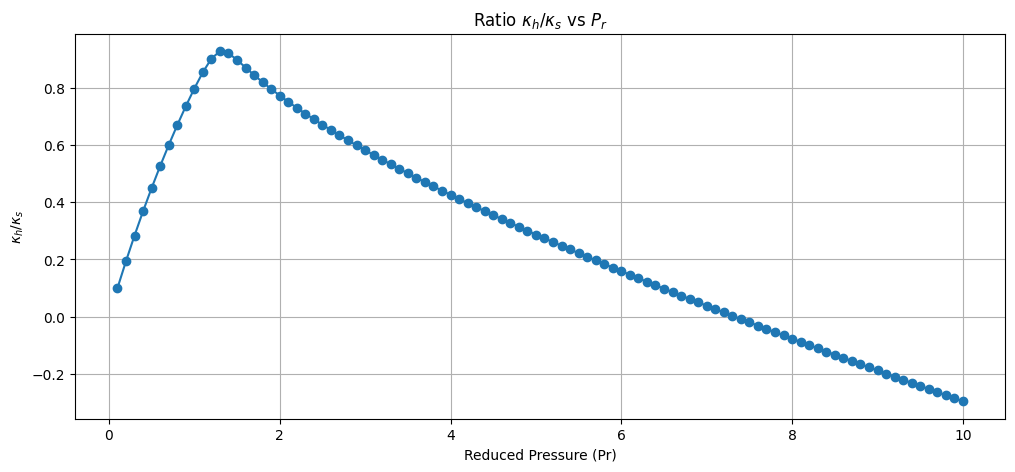

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

def PR_v_and_dv_dT(T, P, Tc, Pc, omega):

    R = scipy.constants.R
    
    # ------- 1) volume at given T and P -----------------------
    κ = 0.37464 + 1.54226*omega - 0.26992*(omega**2)
    tr_sqrt = np.sqrt(T / Tc)      # sqrt(Tr)
    g       = 1.0 + κ*(1.0 - tr_sqrt)
    alpha   = g*g
    # a, b parameters for peng-robinson
    a = 0.45724*(R*Tc)**2 / Pc * alpha
    b = 0.07780*(R*Tc) / Pc
    # Coefficients
    A = b - (R*T)/P
    B = (a/P) - 3*b*b - 2*b*(R*T)/P
    C = b**3 + (b**2*R*T - b*a)/P
    # volume calculation:
    coefs = [1.0, A, B, C]
    roots = np.roots(coefs)
    v_real = roots[np.isreal(roots)].real
    v = np.max(v_real)
    # -----------------------------------------------------------


    # 2) Analytic dv/dT: ----------------------------------------
    #    dv/dT = - (dp/dT)/(dp/dv)   (holding P constant)

    # dp/dv = derivative of [v^3 + A*v^2 + B*v + C] wrt v
    dpdv = 3.0*v**2 + 2.0*A*v + B

    # dp/dT
    dA_dT = - R/P
    da_dT = 0.45724*(R*Tc)**2 / Pc * (2.0*g * (-κ/(2.0*tr_sqrt*Tc)))  # chain rule
    dB_dT = (1.0/P)*da_dT - 2.0*b*(R/P)
    dC_dT = (1.0/P)*(b*b*R - b*da_dT)
    # dp/dT = dA/dT * v^2 + dB/dT * v + dC_dT
    dpdT = dA_dT*(v*v) + dB_dT*v + dC_dT
    dv_dT = - dpdT / dpdv
    # ------------------------------------------------------------
    return v, dv_dT


# ------------------------------------------------------------
# State Properties for CO2 using Peng-Robinson EOS
T_CO2   = 319.4     # K
Tc_CO2  = 304.2     # K
Pc_CO2  = 73.76e5   # Pa
omega   = 0.225

Pr_vals = np.linspace(0.1, 10.0, 100)
ratio_vals = []

for pr in Pr_vals:
    P = pr * Pc_CO2
    v, dv_dT = PR_v_and_dv_dT(T_CO2, P, Tc_CO2, Pc_CO2, omega)
    
    ratio = 1.0 - v / (T_CO2 * dv_dT)
    ratio_vals.append(ratio)

plt.figure(figsize=(12, 5))
plt.plot(Pr_vals, ratio_vals, marker='o', linestyle='-')

plt.xlabel('Reduced Pressure (Pr)')
plt.ylabel(r'$\kappa_h/\kappa_s$')
plt.title(r'Ratio $\kappa_h/\kappa_s$ vs $P_r$')
plt.grid(True)
plt.show()


## Conclusions:

The plot shows how kh / ks varies with reduced pressure P_r  for CO2 at a fixed temperature (319.4 K), using the Peng–Robinson equation of state.

- At **low reduced pressure** $P_r < 1.5 $, the ratio increases, meaning the **throttling process is relatively more efficient** at producing cooling.
- Near the peak $ P_r \approx 1.5 $, both processes have similar cooling effects.
- As pressure increases further $P_r > 2$, the ratio decreases and becomes negative — indicating that **isentropic expansion becomes more effective** than throttling for cooling, and throttling may even cause heating.